In [1]:
!pip install netket

In [2]:
import functools
from typing import Callable

import tqdm
import equinox as eqx
import jax

jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import optax
from jaxtyping import Array, PyTree, Int, Float, Complex, PRNGKeyArray

import netket as nk
from netket.operator import FermionOperator2ndJax
from netket.operator.fermion import destroy as c
from netket.operator.fermion import create as cdag
from netket.operator.fermion import number as nc

from netket.experimental.driver import VMC_SRt
from netket.jax import logdet_cmplx

import matplotlib.pyplot as plt

key = jax.random.key(42)

## Construct Hilbert spaces and Hamiltonian operator
- Hilbertspace
\begin{equation}
    \mathcal H = \operatorname{span}\{\ket{n}:n \in \mathcal L(L_x, L_y, ...)\},\quad F_{-} (\mathcal H) = \bigoplus_{n=0}^\infty S_{-}\mathcal H^{\otimes n}
\end{equation}
Where $\mathcal L(L_x, L_y, ...)$ is square lattice with lengths $L_x, L_y, ...$.


- Hamiltonian operator
\begin{equation}
    H=-t\sum_{\braket{\mathbf r, \mathbf r'}, \sigma} [c_{\sigma}^\dagger(\mathbf r')c_{\sigma}(\mathbf r) + c_{\sigma}^\dagger(\mathbf r)c_{\sigma}(\mathbf r')] + U\sum_{\mathbf r} n_\uparrow (\mathbf r) n_\downarrow (\mathbf r)
\end{equation}


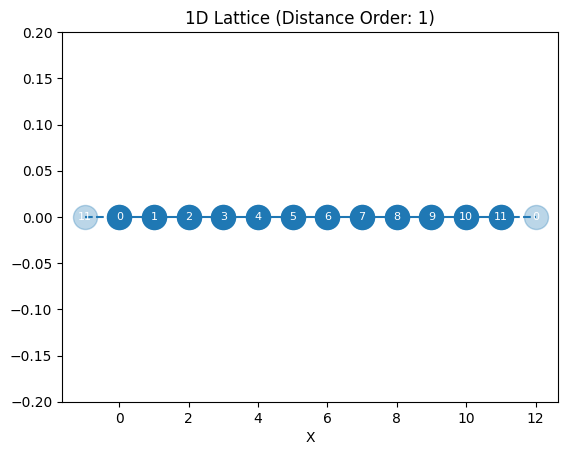

<Axes: title={'center': '1D Lattice (Distance Order: 1)'}, xlabel='X'>

In [3]:
def construct_system(t: float, U: float, N: int, L: list[int], pbc=True) -> tuple[nk.hilbert.SpinOrbitalFermions, FermionOperator2ndJax]:
    hi = nk.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions=N)
    H = FermionOperator2ndJax(hi)

    graph = nk.graph.Grid(L, pbc=pbc)
    for (r1, r2) in graph.edges():
        for s in [-1, 1]:
            H += -t * (cdag(hi, r1, s) * c(hi, r2, s) + cdag(hi, r2, s) * c(hi, r1, s))

    for r in graph.nodes():
        H += U * nc(hi, r, -1) * nc(hi, r, 1)

    return hi, H

t = 1.0
U = 4.0
N = 12
L = [12,]
PBC = True

graph = nk.graph.Grid(L, pbc=PBC)
graph_extended = nk.graph.disjoint_union(graph, graph)

graph.draw()

In [4]:
hi = nk.hilbert.SpinOrbitalFermions(graph.n_nodes, s=1/2, n_fermions=N)

H = FermionOperator2ndJax(hi)
for (r1, r2) in graph.edges():
    for s in [-1, 1]:
        H += -t * (cdag(hi, r1, s) * c(hi, r2, s) + cdag(hi, r2, s) * c(hi, r1, s))

for r in graph.nodes():
    H += U * nc(hi, r, -1) * nc(hi, r, 1)

## Exact Diagonalization

As a reference

In [5]:
sp_h = H.to_numba_operator().to_sparse()

In [6]:
from scipy.sparse.linalg import eigsh

eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

E_gs = eig_vals[0]

print("Exact ground state energy:", E_gs)

Exact ground state energy: -6.920353562418576


## Mean-Field Slater Determinant

\begin{equation}
    \ket{\Phi_s}=\prod_{\alpha=1}^{N_{\mathrm f}}\phi_\alpha^\dagger\ket{0}
\end{equation}

Where $\ket{0}$ is the vacuum state and the single-particle orbitals are created by the operators $\phi_\alpha^\dagger$. In turn, these creation operators are, in general, a linear combination of the original creation operators:
\begin{equation}
    \phi_\alpha^\dagger =\sum_{i} M_{\alpha, i}c_i^\dagger
\end{equation}
The rectangular $(N\times N_{\mathrm f})$ matrix $M$ constitutes a set of free variational parameters (Where $N$ is the number of orbitals and $N_{\mathrm f}$ the number of fermions).

It can be shown that the amplitudes of the wave function in the computational basis $\ket{n_1, ..., n_N}$ are determinants:
\begin{equation}
    \braket{n_1, ..., n_N|\Phi_{s}} = \det\{A(n)\}
\end{equation}
where the $N_{\mathrm f}\times N_{\mathrm f}$ matrix is
\begin{equation}
    A(n)_{\alpha,\beta} = M_{R_\alpha(\mathbf n), \beta},
\end{equation}
where $R_\alpha(\mathbf n)$ denotes the index of the $\alpha$-th occupied site (non-zero $n_i$) in $\mathbf n=(n_1, ..., n_N)$. This can also be interepted as selecting $N_{\mathrm f}$ rows of the matrix $M$ in corresponding to the $N_{\mathrm f}$ occupied orbitals. For more details see Chapter 5 of Reference [1].

To write down this variational amplitudes, we start by defining a convenience function to compute the logarithm of the determinant of a matrix, in the complex domain, and using jax:

In [7]:
@jax.jit
def nkstate_to_indexseq(
    state,
) -> jnp.ndarray:
    return jnp.nonzero(state, size=hi.n_fermions)

def count_parameters(model):
    leaves = jax.tree.leaves(model)
    return sum(x.size for x in leaves if isinstance(x, jnp.ndarray))

class BatchWrapper(eqx.Module):
    submodule: eqx.Module

    def __init__(self, submodule):
        self.submodule = submodule

    def __call__(self, batch, **kwargs):
        outputs = jax.vmap(self.submodule)(batch)
        return outputs

### Simplest Slater Determinant

In [8]:
class LogSlaterDeterminant(eqx.Module):
    embedding: eqx.nn.Embedding

    def __init__(
        self,
        hilbert: nk.hilbert.SpinOrbitalFermions,
        *,
        key: PRNGKeyArray
    ):
        self.embedding = eqx.nn.Embedding(hilbert.size, hilbert.n_fermions, key=key)

    def __call__(
        self,
        state: Int[Array, "hilb_size"]
    ) -> Complex[Array, ""]:
        indices = nkstate_to_indexseq(state)[0]
        A = jax.vmap(self.embedding)(indices)
        return logdet_cmplx(A)

In [9]:
key, subkey = jax.random.split(key)
model = LogSlaterDeterminant(hi, key=subkey)
ma = BatchWrapper(
    model
)
sa = nk.sampler.MetropolisFermionHop(hi, graph=graph_extended)
count_parameters(model)

288

In [10]:
vstate = nk.vqs.MCState(sa, ma, n_samples=2**12, n_discard_per_chain=16)

In [11]:
vstate.samples.shape

(16, 256, 24)

In [12]:
vstate.samples[0,0]

Array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0], dtype=int8)

In [13]:
# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=0.05)

# Create the VMC (Variational Monte Carlo) driver
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

In [14]:
# Construct the logger to visualize the data later on
slater_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=100, out=slater_log)

  0%|          | 0/100 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [15]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -4.494+0.000j ± 0.041 [σ²=3.232, R̂=1.0680]
Relative error   : 0.35066335888661265


### Neural Jastrow

In [16]:
class LogNeuralJastrowSlater(eqx.Module):
    embedding: eqx.nn.Embedding
    jastrow_linear: eqx.nn.Linear

    def __init__(
        self,
        hilbert: nk.hilbert.SpinOrbitalFermions,
        hidden_size: int,
        *,
        key: PRNGKeyArray
    ):
        embedding_key, jastrow_key = jax.random.split(key, 2)
        self.embedding = eqx.nn.Embedding(hilbert.size, hilbert.n_fermions, key=embedding_key)
        self.jastrow_linear = eqx.nn.Linear(
            hilbert.size,
            hidden_size,
            key=jastrow_key
        )

    def __call__(
        self,
        state: Int[Array, "hilb_size"]
    ) -> Complex[Array, ""]:
        indices = nkstate_to_indexseq(state)[0]
        A = jax.vmap(self.embedding)(indices)
        J = self.jastrow_linear(state)
        J = jax.nn.tanh(J)
        J = jnp.sum(J)

        return logdet_cmplx(A) + J

In [17]:
key, subkey = jax.random.split(key)
model = LogNeuralJastrowSlater(
    hilbert=hi,
    hidden_size=hi.size,
    key=subkey
)
ma = BatchWrapper(
    model
)
sa = nk.sampler.MetropolisFermionHop(hi, graph=graph_extended)
vstate = nk.vqs.MCState(sa, ma, n_samples=2**12, n_discard_per_chain=16)
count_parameters(model)

888

In [18]:
# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=0.05)

# Create the VMC (Variational Monte Carlo) driver
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

In [19]:
# Construct the logger to visualize the data later on
nj_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=100, out=nj_log)

  0%|          | 0/100 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [20]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -3.780-0.000j ± 0.024 [σ²=0.899, R̂=1.0870]
Relative error   : 0.4538005480739985


### Self-Attention Ansatz

In [21]:
class AttentionWFN(eqx.Module):
    embedding: eqx.nn.Embedding
    attention: eqx.nn.MultiheadAttention
    ff_layers: eqx.nn.MLP
    use_complex: bool=eqx.field(static=True)

    def __init__(
        self,
        hilbert: nk.hilbert.SpinOrbitalFermions,
        hidden_size: int,
        attention_size: int,
        num_head: int,
        ff_depth: int,
        activation: jax.nn.gelu,
        *,
        use_complex: bool=False,
        key: PRNGKeyArray
    ):
        embedding_key, attention_key, ff_key = jax.random.split(key, 3)
        self.embedding = eqx.nn.Embedding(hilbert.size, hidden_size, key=embedding_key)
        self.attention = eqx.nn.MultiheadAttention(
            num_head,
            hidden_size,
            hidden_size,
            hidden_size,
            hidden_size,
            attention_size,
            attention_size,
            key=attention_key
        )
        ff_out_size = 2 * hi.n_fermions if use_complex else hi.n_fermions
        self.ff_layers = eqx.nn.MLP(
            hidden_size, ff_out_size, hidden_size, ff_depth, activation, key=ff_key
        )
        self.use_complex = use_complex


    def __call__(
        self,
        state: Int[Array, "hilb_size"]
    ) -> Complex[Array, ""]:
        indices = nkstate_to_indexseq(state)[0]
        embedded = jax.vmap(self.embedding)(indices) # (n_fermions, hidden_size)
        atten_out = self.attention(embedded, embedded, embedded) # (n_fermions, hidden_size)
        ff_in = atten_out + embedded
        ff_out = jax.vmap(self.ff_layers)(ff_in)
        if self.use_complex:
            real, imag = jnp.split(ff_out, 2, axis=1)
            ff_out = jax.lax.complex(real, imag)
        return logdet_cmplx(ff_out)

In [22]:
key, subkey = jax.random.split(key)
model = AttentionWFN(
    hilbert=hi,
    hidden_size=24,
    attention_size=24,
    num_head=1,
    ff_depth=2,
    activation=jax.nn.gelu,
    use_complex=True,
    key=subkey
)
ma = BatchWrapper(
    model
)
sa = nk.sampler.MetropolisFermionHop(hi, graph=graph_extended)
vstate = nk.vqs.MCState(sa, ma, n_samples=2**12, n_discard_per_chain=16)
count_parameters(model)

4680

In [23]:
# op = nk.optimizer.Adam(learning_rate=0.001)
# gs = nk.VMC(H, op, variational_state=vstate)

# Define the optimizer
schadule = nk.optimizer.Ex
op = nk.optimizer.Sgd(learning_rate=0.05)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=0.05)

# Create the VMC (Variational Monte Carlo) driver
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)
# gs = VMC_SRt(H, op, variational_state=vstate, diag_shift=0.05)

In [24]:
# Construct the logger to visualize the data later on
atten_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=100, out=atten_log)

  0%|          | 0/100 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [25]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -6.090+0.004j ± 0.043 [σ²=2.552, R̂=1.0875]
Relative error   : 0.11998453110267432


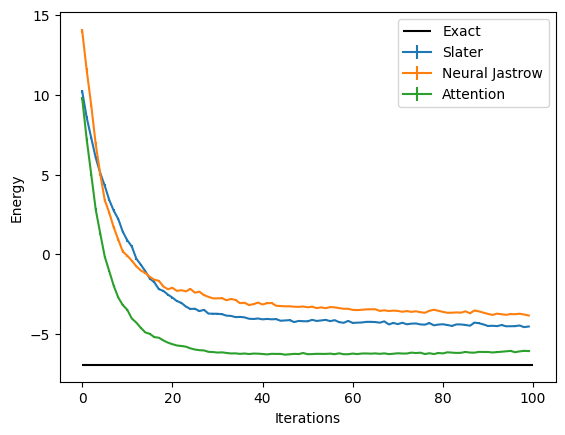

In [27]:
logged_data = (slater_log.data, nj_log.data, atten_log.data)
labels = ("Slater","Neural Jastrow","Attention")

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters, data["Energy"].Mean.real, yerr=data["Energy"].Sigma,label=label)

plt.hlines([E_gs], xmin=0, xmax=100, color='black', label="Exact")

plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()